# Hernquist model + central black hole, at equilibrium

Hernquist two-power model spherical galaxy (Binney \& Tremaine, 2008):

$$\rho(r)=\frac{M}{2\pi a^3}\frac{1}{r\left(1+\frac{r}{a}\right)^3}$$

The potential, including a central black hole, is:

$$
\Phi(r) = -\frac{GM}{a + r} - \frac{GM_{bh}}{r}
$$

**Equilibrium**

For most practical uses stellar systems are approximated collisionless: star's orbits can be described as if the potential is generated by the smooth mass density distribution rather than each point-like source individually. The collisionless approximation holds as long as the system evolves for a time shorter than the relaxation time: 

$$t_{relax}=\frac{0.1N}{\ln{N}}t_{cross}$$

where $t_{cross}$ is the typical dynamical timescale of the galaxy (the time it takes a typical star to complete one orbit around the system). In any collisionless system it is usefull to define the distribution function (DF). It expresses at any time $t$ the probability of finding a randomly chosen star at point $\boldsymbol{w}=(\boldsymbol{x},\boldsymbol{v})$ in phase space: 

$$\int d^3\boldsymbol{x} d^3\boldsymbol{v} f(\boldsymbol{x},\boldsymbol{v},t) = 1 $$
The DF satisfies the collisionless Boltzmann equation, which represents the conservation of probability in phase space, analogous to how the continuity equation represents mass conservation:

$$  \frac{\partial f}{\partial t} + \frac{\partial}{\partial \boldsymbol{w}}\cdot (f\dot{\boldsymbol{w}}) = 0$$

Jeans theorem states that a solution of the collisionless Boltzmann equation is steady if and only if it depends on the phase space coordinates only through integrals of motion in the given potential. 
In any steady state potential $\Phi(\boldsymbol{x})$ the energy $H = \frac{1}{2}v^2 + \Phi(\boldsymbol{x})$ is an integral of motion. All stellar systems which DF is a function of the energy only are at equilibrium and are called ergodic. It's easy to prove that the mean velocity vanishes everywhere and the velocity dispersion is isotropic:

$$ \sigma_{ij}^2 = \overline{v_iv_j}-\overline{v_i}\, \overline{v_j}=\overline{v_iv_j}=\sigma^2\delta_{ij}$$

A self-consistent system is a system which density distribution generates the potential through Poisson's equation and the potential determines the density according to the collisionless Boltzmann equation. Hernquist mass distribution has spherical symmetry so it's most conveniently described by spherical coordinates. It's useful to define new variables:

$$\Psi = -\Phi + \Phi_0  \quad \quad  \mathcal{E} = -E + \Phi_0 = \Psi - \tfrac{1}{2}v^2$$

$\Phi_0$ is chosen such that $f>0$ if $\mathcal{E}>0$ and $f=0$ if $\mathcal{E}\leq 0$. For an isolated system, $\Phi_0=0$ and the relative energy is equal to the binding energy. With this new coordinates Poisson's equation simply reads: $\nabla^2 \Psi = -4\pi G \rho$.
If the system is ergodic mass density satisfies:

$$\nu(r)=\frac{\rho(r)}{M} = \int_0^{\sqrt{2\Psi}} dv 4\pi v^2 f(\Psi-\tfrac{1}{2} v^2)= 4\pi \int_0^{\sqrt{2\Psi}} d\mathcal{E} f(\mathcal{E})\sqrt{2(\Psi-\mathcal{E})}$$

Expressing $\rho$ as a function of $\Psi$ ($\Psi$ is a monotonic function of $\nu$): 

$$    \frac{1}{\sqrt{8}\pi}\nu(\Psi)=2 \int_0^{\Psi} d\mathcal{E} f(\mathcal{E})\sqrt{\Psi-\mathcal{E}}$$

differentiating left and right and recognizing the resulting Abel integral equation, we finally get the Eddington formula, that permits to find a consistent DF for the given spherical distribution and potential: 

$$    f(\mathcal{E})=\frac{1}{\sqrt{8}\pi^2}\frac{d}{d\mathcal{E}}\int_0^{\mathcal{E}} \frac{d\Psi}{\sqrt{\mathcal{E}-\Psi}}\frac{d\nu}{d\Psi}$$
The only constrain is that the solution $f(\mathcal{E})$ must be nowhere negative and this happens only if the integral over energies in the Eddington formula is an increasing function of $\mathcal{E}$. 

# Initialize Hernquist model

**Build the DF**

1. Initialize arrays for the potential and mass density:

$$
\nu(r) = \frac{\rho(r)}{M} = \frac{1}{r/a (1 + r/a)^3}
$$

$$
\Psi(r) = \frac{M}{a + r} + \frac{M_{bh}}{r}
$$

2. Compute the Derivative $\frac{d\nu}{d\Psi}$ using numerical gradients.

3. Evaluate the Integral in the **Eddington formula** for an array of energies $\mathcal{E}$.

4. Interpolate the DF using cubic interpolation.

**Sampling Positions**

The cumulative mass profile is:

$$
M(r) = M \frac{r^2}{(r + a)^2}
$$

To sample radii from a uniformly distributed mass fraction $m_r = M(r)$, invert the relation:

$$
r = a \left(\frac{m_r}{1 - m_r}\right)
$$

**Sampling Velocities via Inverse Sampling Method**

The distribution function $f(\mathcal{E})$ allows us to sample the binding energy $E$ using **inverse sampling**:

Cumulative distribution function (CDF) has to be computed for every particle (it depends on $Psi(r)$:

$$
F(E) = \int_0^E 4 \pi f(\mathcal{E}) \sqrt{2(\Psi - \mathcal{E})} \, d\mathcal{E}
$$

maximum value of $E$ is when $\mathcal{E}=\Psi_{esc}$ i.e. the velocity is equal to escape velocity.
Inverse CDF sampling:

$$
E = F^{-1}(U) \quad \text{where} \quad U \sim \mathcal{U}[0,1]
$$

The inverse function is computed numerically.
Once the binding energy $E$ is sampled, the velocity magnitude is:

$$
v = \sqrt{2(\Psi - E)}
$$





In [46]:
from myTreecode import Star
from myTreecode import Tree
from myTreecode import grav_force_star_node
from myTreecode import evolve
from view import view

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.integrate import quad
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [47]:
time_conversion_factor = 14.910128      # 1 IU in Myrs
energy_conversion_factor = 1/1524.834   # sun kinetic energy in internal units
velocity_conversion_factor = 1 / 15.248335  # 1 IU in Km/s 
time_conversion_factor_s = 470563626066861.375000 # 1 IU in s

In [70]:
class Hernquist:
    
    def __init__(self,N,a,m=1,M_bh=0,plot=False):
        self.N = int(N) 
        self.a = a 
        self.m = m 
        self.M = N*self.m   # stellar mass
        self.rho0 = self.M / (2*np.pi*self.a**3) 
        self.M_bh = M_bh

        
        print(f"Hernquist model of {self.N} stars and total mass {self.M:.2f} solar masses. "
              f"Scale parameter a is {self.a:.2f} parsecs.")
        if M_bh > 0: print(f"Central black hole of mass {M_bh:.2f}")

        self.v_typical = np.sqrt((self.M + M_bh)/ self.a)  # from virial theorem
        self.t_cross = self.a / self.v_typical        
        self.t_relax = (0.1 * self.N / np.log(self.N)) * self.t_cross

        print(f"Characteristic velocity is {self.v_typical:.2e} in internal units, "
              f"{self.v_typical * velocity_conversion_factor:.2e} km/s. ")
        print(f"Crossing time is {self.t_cross:.2e} in internal units, "
              f"{self.t_cross * time_conversion_factor:.2e} Myr. "
              f"Relaxation time is {self.t_relax:.2e} in internal units, "
              f"{self.t_relax * time_conversion_factor:.2e} Myr.")


        ### initialize arrays for numeric DF calculation ###
  
        r_array = np.logspace(-4,4,100000) * self.a  
        nu = self.rho0 / self.M / ((r_array/a) * (1+r_array/a)**3)      # mass probability distribution
        Psi = self.M / self.a / (1+r_array/a)  +  self.M_bh/r_array     # potential
        nu = nu[::-1] 
        Psi = Psi[::-1]
        dnu_dPsi = np.gradient(nu, Psi)
        
        E_array = np.logspace(np.log10(min(Psi)), np.log10(max(Psi)),1000) 
        
        Y = []
        for E in E_array: 
            Y.append(quad(lambda psi: np.interp(psi, Psi, dnu_dPsi) / np.sqrt(E - psi), 0, E)[0])

        DF_num = 1/(2**(3/2) * np.pi**2) * np.gradient(Y,E_array)
        DF_fun = interp1d(E_array, DF_num, kind='cubic', fill_value="extrapolate")

        
        # initialize system

        
        self.t = [0]
        self.system = []

        initial_conditions = []

        if M_bh > 0:
            initial_conditions.append(Star(M_bh,np.array([0,0,0]),np.array([0,0,0])))
            self.N = self.N + 1

        for i in range(N):
            
            #inizialize position 
            
            m_r = random.uniform(0,self.M)
            x = 2 * np.pi * self.rho0 * self. a / m_r
            y = 1 / self.a
            r = (-y-np.sqrt(x))/(y**2-x) 
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)
            x = np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])

            # initialize velocity

            # inverse sampling
            Psi_particle = self.M/(self.a + r) + self.M_bh / r
            E_array = np.linspace(0,Psi_particle,100)

            F = [0] 
            for k in range(1,len(E_array)):
                F.append(F[k-1] + quad(lambda e: 4*np.pi * DF_fun(e) * np.sqrt(2 * (Psi_particle - e)), E_array[k-1],E_array[k])[0])

            inverse_integral = interp1d(F,E_array,kind='linear')

            nu_r = self.rho0 / (r/self.a*(1+r/self.a)**3) / self.M  # normalization
            F_e = random.uniform(0,nu_r)
            if F_e < max(F):
                E = inverse_integral(F_e) 
            else:
                E = inverse_integral(max(F)) 
 
            v_magn = np.sqrt(2*(Psi_particle - E))
            theta = np.arccos(1-2*random.uniform(0,1)) 
            phi = 2*np.pi*random.uniform(0,1)

            v = np.array([v_magn*np.sin(theta)*np.cos(phi),v_magn*np.sin(theta)*np.sin(phi),v_magn*np.cos(theta)])

            initial_conditions.append(Star(self.m, x, v))
        
        self.system.append(np.array(initial_conditions))


        # check sampling 

        if plot:

            fig,ax = plt.subplots(2,2,figsize=(10,10))
            ax = ax.flatten()
            
            valid_stars = [star for star in initial_conditions if star.r != 0]
            
            R_sampled = np.array([star.r for star in valid_stars])
            E_sampled = np.array([self.M / (star.r + self.a) + self.M_bh / star.r - 0.5 * np.linalg.norm(star.v)**2 for star in valid_stars])
            
            ax[0].hist(np.log10(R_sampled/self.a), bins=20, color = "red", ec="black") 
            ax[1].hist(np.log10(E_sampled[np.log10(E_sampled/(hern.M/hern.a))>-4]/(hern.M/hern.a)),bins=20, color = "blue", ec="black")

            ax[0].set_xlabel("log(r/a)")
            ax[1].set_xlabel("log($\mathcal{E}/(GM/a))$")

            # mass distribution
            
            R_hist = np.histogram(R_sampled, bins=np.logspace(np.log10(min(R_sampled)),np.log10(max(R_sampled)),11)) 
            R_bin = [] 
            R_dens = [] 
            R_err = []
            for i in range(len(R_hist[1])-1):
                if R_hist[0][i] > 0:
                    R_bin.append((R_hist[1][i]+R_hist[1][i+1])/2)
                    V = 4/3 * np.pi * (R_hist[1][i+1]**3 - R_hist[1][i]**3) 
                    R_dens.append(R_hist[0][i] / V)
                    R_err.append(1/np.sqrt(R_hist[0][i])) 
            R_bin = np.array(R_bin) 
            R_dens = np.array(R_dens)
            R_err = np.array(R_err)

            r_array_long = np.logspace(np.log10(min(R_sampled)),np.log10(max(R_sampled)),100)
            rho = self.rho0 / ((r_array_long/self.a) * (1+r_array_long/self.a)**3) 

            ax[2].plot(np.log10(r_array_long/self.a),np.log10(rho/self.rho0),c='red')
            ax[2].errorbar(np.log10(R_bin/self.a),np.log10(R_dens/self.rho0),yerr=R_err, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
            ax[2].set_xlabel("log($r/a$)")
            ax[2].set_ylabel("log($\\rho/\\rho_0$)")


            # energy distribution

            def integrand(r,E):
                return 16 * np.pi**2 * r**2 * np.sqrt(2* (self.M/(r+self.a) + self.M_bh/r - E) ) if  self.M/(r+self.a) + self.M_bh/r >= E else 0

 
            E_hist = np.histogram(E_sampled, bins=np.logspace(np.log10(1.e-1*self.M/self.a),np.log10(max(E_sampled)),11))  
            E_bin = [] 
            E_dens = [] 
            E_err = []
            for i in range(len(E_hist[1])-1):
                if E_hist[0][i] > 0:
                    E_bin.append((E_hist[1][i]+E_hist[1][i+1])/2)
                    V = integrate.quad(lambda E : integrate.quad(integrand,0,np.inf,args=(E))[0],E_hist[1][i],E_hist[1][i+1])[0]  
                    E_dens.append(E_hist[0][i] / V /hern.N)  # justify division by N
                    E_err.append(1/np.sqrt(E_hist[0][i])) 
            E_bin = np.array(E_bin) 
            E_dens = np.array(E_dens)
            E_err = np.array(E_err)

            E_array_long = np.logspace(np.log10(1.e-1*self.M/self.a),np.log10(max(E_sampled)),100)
            
            ax[3].plot(np.log10(E_array_long/(self.M/self.a)),np.log10(DF_fun(E_array_long)*(self.M*self.a)**(3/2) ),c='blue')  
            ax[3].errorbar(np.log10(E_bin/(self.M/self.a)),np.log10(E_dens*(self.M*self.a)**(3/2) ),yerr=3*E_err, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black') 
            ax[3].set_xlabel("log$[\mathcal{E}/(GM/a)]$")
            ax[3].set_ylabel("log$[(GMa)^{3/2}f]$")    







Hernquist model of 1000 stars and total mass 1000.00 solar masses. Scale parameter a is 100.00 parsecs.
Central black hole of mass 100.00
Characteristic velocity is 3.32e+00 in internal units, 2.18e-01 km/s. 
Crossing time is 3.02e+01 in internal units, 4.50e+02 Myr. Relaxation time is 4.36e+02 in internal units, 6.51e+03 Myr.


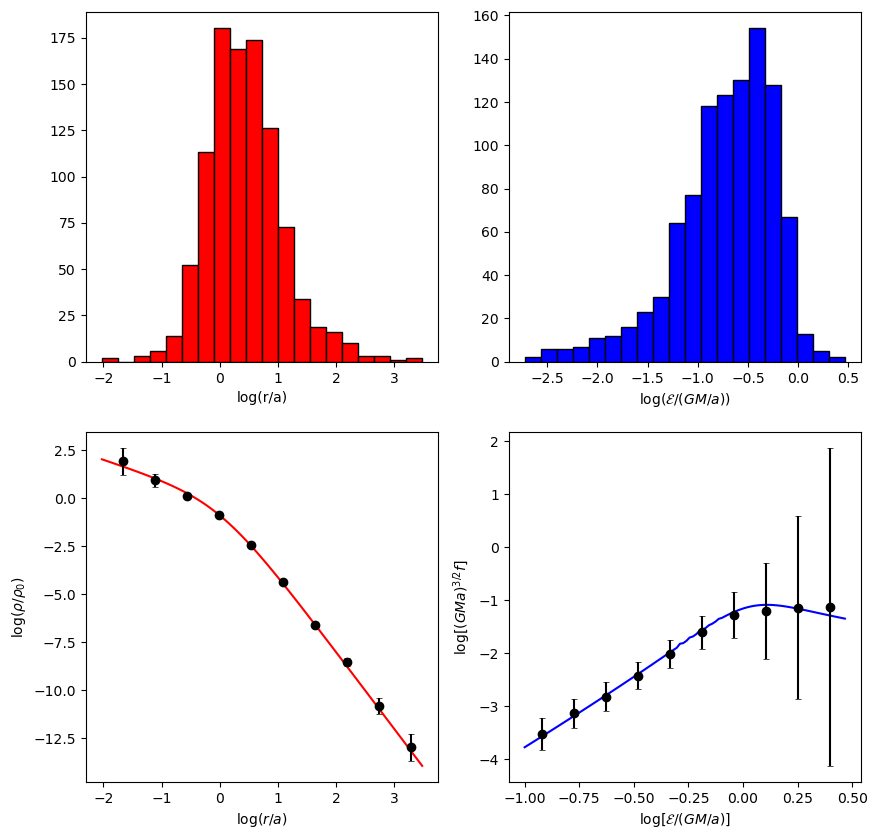

In [71]:
hern = Hernquist(N=1000,a=100,m=1,M_bh=100,plot=True)

In [31]:
evolve(hern,tstop = 400,dt = 5,dtout=10,eps=0.001,orbit_indexes=[20,60,70,1,2,3])

Evolving system:   0%|          | 0/400 [00:00<?, ?it/s]

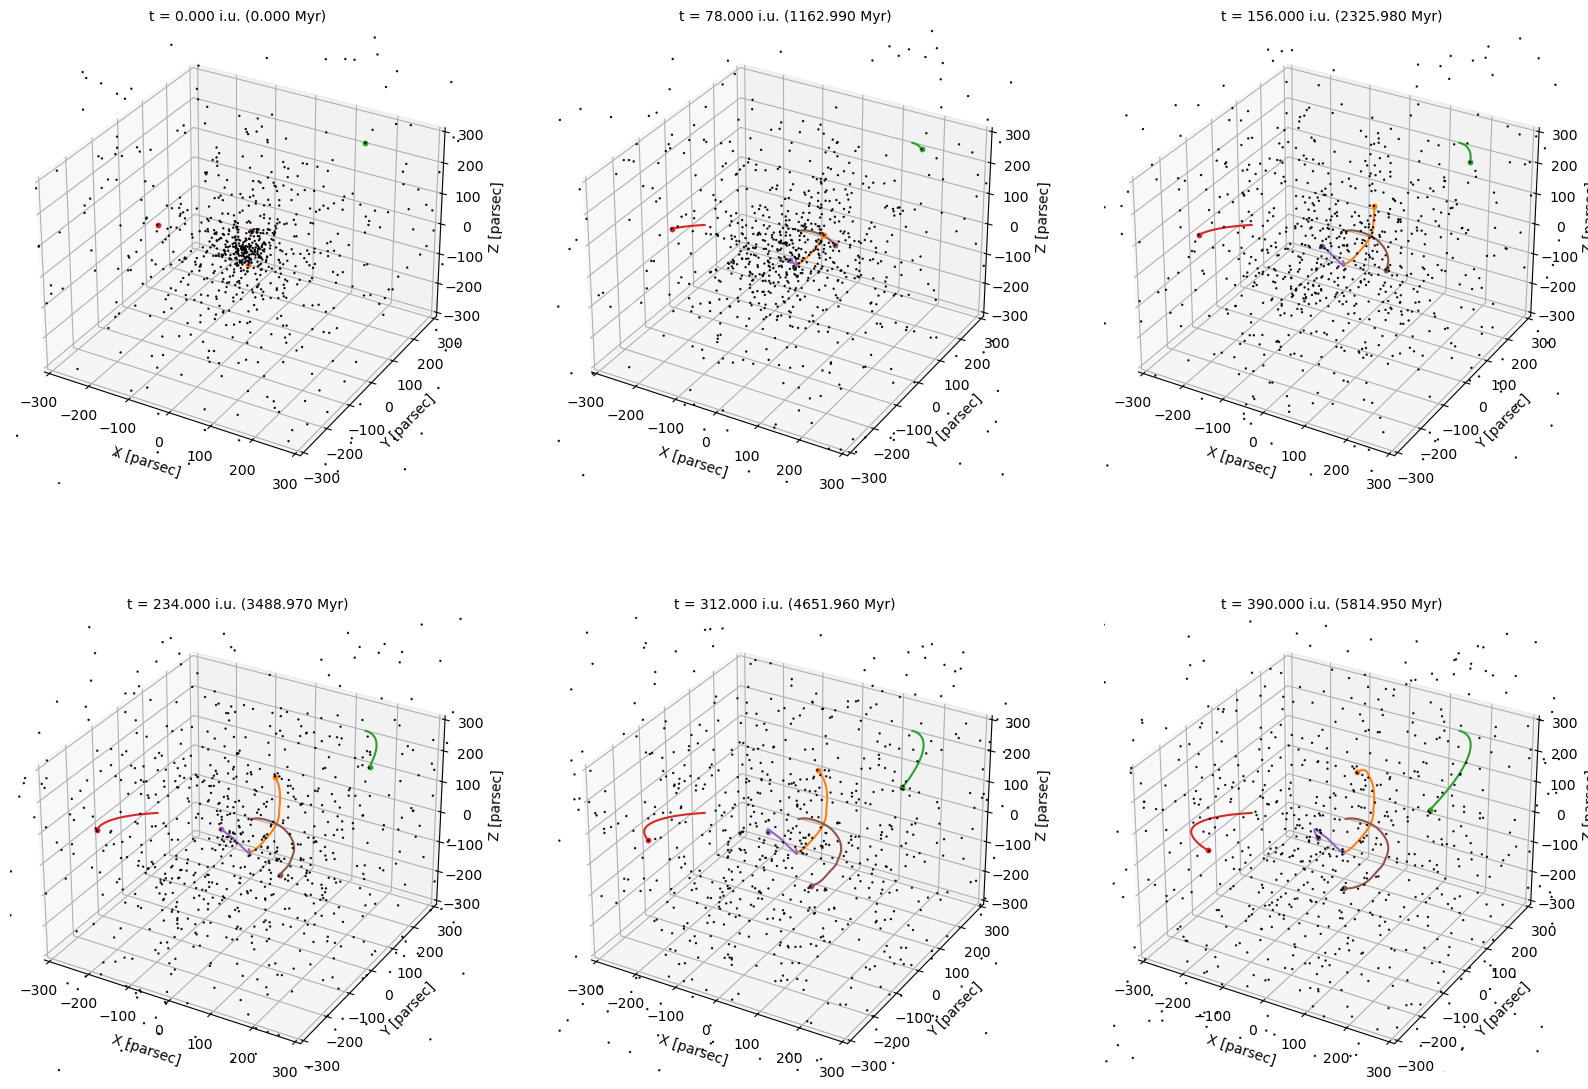

In [32]:
view(hern,r_max=300, t=np.linspace(hern.t[0],hern.t[-1],6))

# Kinematic Signature of a Central Black Hole

The presence of a central black hole in a Hernquist galaxy can be revealed by analyzing the stellar velocity dispersion profile using the Jeans equation:

For a **spherically symmetric** and **isotropic** system, the Jeans equation reads:

$$\frac{d(\nu \sigma_r^2)}{dr} + \nu \frac{d\Phi}{dr} = 0$$

The radial velocity dispersion can be obtained by integrating the **Jeans equation**:

$$\sigma_r^2(r) = \frac{1}{\nu(r)} \int_r^\infty \nu(r') \frac{d\Phi}{dr'} dr'$$



- In the **absence of a black hole**, the **velocity dispersion** profile declines smoothly with radius.  
- When a **black hole** is present, the **velocity dispersion** rises significantly towards the center, following approximately:

$$\sigma_r(r) \sim \sqrt{\frac{G M_{bh}}{r}}$$

This **kinematic signature** serves as a **diagnostic tool** to **infer the presence and mass** of a **central black hole** by comparing **observed** and **predicted** **velocity dispersion profiles**. 
The **projected velocity dispersion** $\sigma_\parallel(R)$ is given by:

$$\sigma_\parallel^2(R) = \frac{2}{\rho_{norm}(R)} \int_R^\infty \sigma_r^2\,\rho(r) \, \frac{r \, dr}{\sqrt{r^2 - R^2}}$$



In [73]:
# How to infer the presence of the central black hole from stellar kynematics ?

### analytic curves 

def sigma_r_analytic(r,M,a,M_bh):  
    mu = M_bh/M
    x = r/a
    y = 1 + x
    return np.sqrt((M/a)*((1+6*mu)*x*y**3 *np.log(y/x) - mu*y**3*(3*x-1/2)/x - x*(1/4+1/3*y+(1+mu)/2*y**2+(1+3*mu)*y**3)/y))

from scipy import integrate
def sigma_LOS_analytic(R,M,a,M_bh):
    rho0 = M/(2*np.pi*a**3)
    rho = lambda r: rho0/(r/a*(1+r/a)**3)
    rho_norm = integrate.quad(lambda r: rho(r) * r /(r**2-R**2)**(1/2), R, np.inf)[0]
    return np.sqrt(1/rho_norm * integrate.quad(lambda r: rho(r) * sigma_r_analytic(r,M,a,M_bh)**2 *r /(r**2-R**2)**(1/2), R, 1.e3*a)[0])

            
from sympy import sin, cos, pi

def black_hole_diagnostic(galaxy,r_max,dr,time = 0, M_bh = [0]): 
        
    if time > galaxy.t[-1]: time=galaxy.t[-1] 
    frame = np.digitize(time,galaxy.t)-1

    i, alpha, beta, gamma = 0,0,0,0
    LOS = np.array([cos(alpha)*cos(beta),sin(alpha)*cos(beta),-sin(beta)])
    sky_plane_x = np.array([cos(alpha)*sin(beta)*sin(gamma) + sin(alpha)*cos(gamma),sin(alpha)*sin(beta)*sin(gamma) + cos(alpha)*cos(gamma),cos(beta)*sin(gamma)])
    sky_plane_y = np.array([cos(alpha)*sin(beta)*cos(gamma) + sin(alpha)*sin(gamma),sin(alpha)*sin(beta)*cos(gamma) - cos(alpha)*sin(gamma),cos(beta)*cos(gamma)])

    #radial component
        
    r = np.arange(0, r_max+dr, dr)             # radial bin
    R = np.arange(0, r_max+dr, dr)             # projected radii

    v_at_r = [ [] for _ in range(len(r))] 
    v_LOS_R = [ [] for _ in range(len(R))] 

    for star in galaxy.system[frame]:
        if 0 < star.r < r_max+dr:
            j = np.digitize(star.r,r) -1
            theta = np.arccos(star.x[2]/star.r) 
            phi = np.arctan(star.x[1]/star.x[0])
            r_versor = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
            v_at_r[j].append(float(np.dot(star.v,r_versor))) 

            star_sky_x = np.dot(star.x,sky_plane_x)
            star_sky_y = np.dot(star.x,sky_plane_y)
            p = np.sqrt(float(star_sky_x)**2+float(star_sky_x)**2)
            k = np.digitize(p,r)-1
            v_LOS_R[k].append(float(np.dot(star.v,LOS))) 

    r_bin = []          
    R_bin = []
    sigma_r = []  
    error_sigma_r = []
    sigma_LOS = []
    error_sigma_LOS = []

    for i in range(len(r)-1):

        # radial spherical shells
        r_bin.append((r[i]+r[i+1])/2)        
        sigma_r_val = np.std(v_at_r[i],ddof=1)
        sigma_r.append(sigma_r_val)

        # error on the velocity dispersion: 
        N_bin = len(v_at_r[i]) 
        error_sigma_r_val = sigma_r_val/np.sqrt(2*N_bin)
        error_sigma_r.append(error_sigma_r_val)

        # projected radius in the plane of the sky
        R_bin.append((R[i]+R[i+1])/2)

        sigma_LOS_val = np.std(v_LOS_R[i],ddof=1)
        sigma_LOS.append(sigma_LOS_val)

        # error on sigma_LOS
        N_bin = len(v_LOS_R[i]) 
        error_sigma_LOS_val = sigma_LOS_val/np.sqrt(2*N_bin)
        error_sigma_LOS.append(error_sigma_LOS_val)


    r_bin = np.array(r_bin)
    R_bin = np.array(R_bin)
    sigma_r = np.array(sigma_r) * velocity_conversion_factor                      # km/s
    error_sigma_r = np.array(error_sigma_r) * velocity_conversion_factor 
    sigma_LOS = np.array(sigma_LOS) * velocity_conversion_factor 
    error_sigma_LOS = np.array(error_sigma_LOS) * velocity_conversion_factor 


    # plots #
     
    fig, axes = plt.subplots(1,2,figsize=(10.5,5.5),layout="constrained") 

    
    axes[0].errorbar(r_bin/hern.a,sigma_r,yerr=error_sigma_r, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
    axes[0].set_ylabel("$\sigma_r$ [km/s]")
    axes[0].set_xlabel("$r/a$")

    
    axes[1].errorbar(r_bin/hern.a,sigma_LOS,yerr=error_sigma_LOS, linestyle='None',marker='o',capsize=2, capthick=0.5,c='black')
    axes[1].set_ylabel("$\sigma_\parallel$ [km/s]")
    axes[1].set_xlabel("$R/a$")    
    
    ### predicted curves
    
    r = np.linspace(0,r_max+dr) 
    R = np.linspace(0,r_max+dr) 

    cmap = plt.get_cmap('rainbow', len(M_bh))

    for i in range(len(M_bh)): 
    
        r_dynamical = (1/hern.a - np.sqrt(2*np.pi*(hern.M/(2*np.pi*hern.a**3))*hern.a/M_bh[i]))/(1/hern.a**2-2*np.pi*(hern.M/(2*np.pi*hern.a**3))*hern.a/M_bh[i]) if M_bh[i] > 0 else 0
        
        sigma_LOS_pred = []
        for k in range(len(R)):
            sigma_LOS_pred.append(sigma_LOS_analytic(R[k],hern.M,hern.a,M_bh[i]))
        sigma_LOS_pred = np.array(sigma_LOS_pred) *  velocity_conversion_factor 
        
        chi2_sum = 0
        ddof = len(sigma_LOS)-1
        for k in range(len(sigma_LOS)):
            chi2_sum = chi2_sum + (sigma_LOS[k]-np.interp(R[k],R,sigma_LOS_pred))**2/error_sigma_LOS[k]**2

        print("M_bh = %.2f : chi2 = %.2f, ddof = %i" %(M_bh[i],chi2_sum,ddof))

        axes[1].plot(R/hern.a,sigma_LOS_pred, c = cmap(i), label="%i, $\chi^2$ = %.1f"%(M_bh[i],chi2_sum))     
        if M_bh[i] > 0:
            axes[0].axvline(x=r_dynamical/hern.a, linestyle=':', c = cmap(i)) 
            axes[1].axvline(x=r_dynamical/hern.a, linestyle=':', c = cmap(i)) 
    
    axes[1].legend(title = "$M_{bh}/M_\odot$",loc="upper right")

    plt.show()



M_bh = 0.00 : chi2 = 114.05, ddof = 9
M_bh = 10.00 : chi2 = 92.73, ddof = 9
M_bh = 100.00 : chi2 = nan, ddof = 9


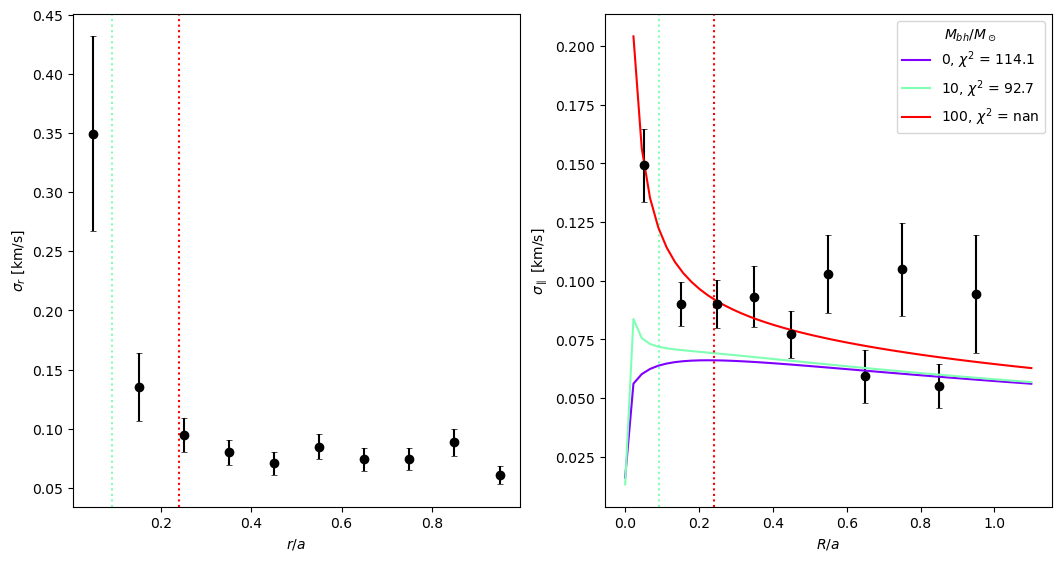

In [75]:
black_hole_diagnostic(hern,r_max=100,dr=10,time = 0, M_bh = [0,10,100])


Given a minimum sensitivity of an instrument of angular resolution A (in arcsec$^2$), what is the minimum number of stars that must fall in each bin in order to produce a signal? Suppose each star is $1 L_\odot$, and located at distance $d$. The flux is: 

$$F = \frac{L_\odot}{4\pi d^2}$$

and the surface brightness is: 

$$B = \frac{F}{A}$$ (in erg/s/cm$^2$/arcsec$^2$). The minimum number of stars of $1L_\odot$ to produce the minimum flux is:

$$N_{\odot,min} = \frac{F_{min}}{F_\odot} = \frac{F_{min}}{L_\odot} 4\pi d^2 $$

in terms of Flux. In terms of surface brightness: 

$$N_{\odot,min} = \frac{B_{min}}{F_\odot/A} = \frac{B_{min}}{L_\odot} 4\pi d^2 A $$

in terms of surface brightness, integration time, mass-to-light ratio

$$N_{\odot,min} = \frac{B_{min,1h}/t_{obs}}{M_*/\Upsilon} 4\pi d^2 A$$



In [17]:
A = 1 #arcsec^2
t_obs = 1 #hours
d = 1.e6 #pc
d_cm = d / 3.24078e-19
F_min = 3.6e-29 #erg cm^-2 s^-1 Hz^-1 sensitivity flux for SDSS in r band
L_sun_r = 6.5e32/(0.7e14) #erg/s/Hz luminosity of sun in r band per Hz
F_min_sun = F_min/L_sun_r
B_min = F_min_sun/A
N_min = B_min / t_obs * 4*np.pi * d_cm**2 * A
#print("Minimum number of stars that must fall in each 1 arcsec^2 bin is: %f" %N_min)

3.876923076923077e-48
Minimum number of stars that must fall in each 1 arcsec^2 bin is: 46.387178


In [64]:


def observation_hernquist(hern,model=None,time=0,
                          i=0,alpha=0,gamma=0,distance=1000,
                          angular_resolution=1,FOV=1.e3, 
                          sensitivity = 3.6e-29, saturation = 3.6e-20, exposure_h = 1,
                          spectral_resolution=2000, spectral_saturation = 500,
                          filename=None):

    #distance in pc, angular resolution and FOV in arcsec, sensitivity (in r band) in erg/s/cm^2/Hz/arcsec (SDSS), exposure in hours
    #spectral resolution adimensional, spectral saturation in km/s
    
    if model == None: model = [hern.M,hern.a,hern.M_bh,1] #hern.mass_light_ratio = 1
    mass_light_ratio = 1

    angular_conv = 206265/distance    #arcsec  converts distances in angular spearation in the sky, in arcsec
    A = angular_resolution**2         #area of 1 bin
    distance_cm = distance/ 3.24078e-19  #distance in cm
    L_sun_r = 6.5e32/(0.7e14) #erg/s/Hz specific luminosity of sun in r band 
    B_min_sun_r = sensitivity/L_sun_r/A  #sensitivity in units of specific Sun luminosity in r band
    B_max_sun_r = saturation/L_sun_r/A
    
    #check mass to light! 
    
    n_surface_bright_min = B_min_sun_r / exposure_h /(hern.m/mass_light_ratio) * 4*np.pi * distance_cm**2 * A       # minimum number of 1 solar mass stars that must fall in a bin of resolution to give a non zero signal
    n_surface_bright_max = B_max_sun_r / exposure_h /(hern.m/mass_light_ratio) * 4*np.pi * distance_cm**2 * A       #1 solar mass produces 1.e33 erg/s in r band, the minimum surface brightness detectable is 4.e-14 erg/s/arcsec corresponding to 10^19 solar type stars
    surface_brightness_conv = L_sun_r*(hern.m/mass_light_ratio)*exposure_h/(4*np.pi*distance_cm**2)
    
    print("Signal above threshold if more than %.1f stars/arcsec^2" %(n_surface_bright_min/A))
    print("Saturation point set at %1f stars/arcsec^2" %(n_surface_bright_max/A))
    
    delta_v_min = 2.99792458 * 10**5/velocity_conv / spectral_resolution               #minimum velocity detectable 
    delta_v_max = spectral_saturation/velocity_conv                                    #maximum velocity in km/s
    
    print("Minimum velocity detectable with given resolution is %.2f km/s" %(delta_v_min*velocity_conv))
    
    r_max = FOV/2 /angular_conv
    dr = angular_resolution/angular_conv
    print("R covered by FOV is %.2f pc, dr is %.2f pc"%(r_max,dr))

    ###  projection  ###

    sky_p = sky_projection(hern,r_max,dr,time,i,alpha,gamma)
    
    bins = [sky_p[0][0]*angular_conv, sky_p[0][1]*angular_conv]
    ra = np.array(sky_p[1])*angular_conv
    dec = np.array(sky_p[2])*angular_conv
    LOS_v_mean = sky_p[3]
    LOS_v_dispersion = sky_p[4]
    LOS_v_disp_errors = sky_p[5]

    ###  plot definition  ###

    fig, axes = plt.subplots(1, 3, figsize=(12,4),layout="constrained") 
    for i in range(3):
        axes[i].set_aspect('equal') 
        axes[i].set_xlabel("ra ['']") 
        axes[i].set_ylabel("dec ['']")

    
    #ticks
    
    R = np.array([0.1*hern.a,0.5*hern.a,hern.a,10*hern.a,50*hern.a,100*hern.a])
    SB_ticks = []
    sigma_LOS_ticks = []
    for r in R:
        if 2*dr < r < r_max: 
            sb_obs = surface_brightness(r,mass_light_ratio,M=hern.M,a=hern.a)
            sb_mod = surface_brightness(r,mass_light_ratio,M=model[0],a=model[1])
            sigma_obs = sigma_LOS(r,M=hern.M,a=hern.a,M_bh=hern.M_bh)
            sigma_mod = sigma_LOS(r,M=model[0],a=model[1],M_bh=model[2])
            print("R = %.1f pc" %r) 
            print("  SB_obs = %.1e, SB_model = %.1e    erg/s/cm^2/arcsec^2/Hz" %(sb_obs*surface_brightness_conv,sb_mod*surface_brightness_conv))
            print("  sigma_LOS_obs = %.1f, sigma_LOS_model = %1.f   km/s" %(sigma_obs*velocity_conv,sigma_mod*velocity_conv))
            SB_ticks.append(sb_obs)
            sigma_LOS_ticks.append(sigma_obs)

    SB_ticks = [sb for sb in SB_ticks if n_surface_bright_min <= sb <= n_surface_bright_max]
    sigma_LOS_ticks = [los for los in sigma_LOS_ticks if delta_v_min <= los <= delta_v_max]
    SB_ticks.append(n_surface_bright_min) ; SB_ticks.append(n_surface_bright_max) ; SB_ticks.sort()
    sigma_LOS_ticks.append(delta_v_min) ; sigma_LOS_ticks.append(delta_v_max) ; sigma_LOS_ticks.sort()

    #SURFACE BRIGHTNESS
    
    cmap = cm.rainbow
    cmap.set_under('w')  
    S = axes[0].hist2d(ra, dec, bins=bins,cmap=cmap,norm=mcolors.LogNorm(vmin=n_surface_bright_min,vmax=n_surface_bright_max)) 
    N = S[0]  
    cbar_sb = fig.colorbar(S[3], ax=axes[0], ticks=SB_ticks, location='bottom', label="surface brightness (r band) [erg/s/cm^2/Hz/arcsec$^2$]" )
    cbar_sb.set_ticklabels(["{:.1e}".format(i*surface_brightness_conv) for i in SB_ticks]) 
    

    #MEAN VELOCITY

    masked_LOS_v_mean = np.where((N < n_surface_bright_min) | (np.abs(LOS_v_mean) < delta_v_min), np.nan, LOS_v_mean)*velocity_conv
    cmap = cm.bwr #cm.spring
    cmap.set_bad(color='yellow')  
    
    V_mean = axes[1].imshow(masked_LOS_v_mean, interpolation='none', extent=[-FOV/2, FOV/2,-FOV/2, FOV/2],origin='lower',cmap=cmap)  
    fig.colorbar(V_mean, ax=axes[1], location='bottom', label="$v_\parallel [km/s]$") #mass_to_light_ratio
    
    #VELOCITY DISPERSION

    masked_LOS_v_dispersion = np.where((N < n_surface_bright_min) | (LOS_v_dispersion < delta_v_min), np.nan, LOS_v_dispersion)
    cmap = cm.viridis
    cmap.set_bad(color='white')  
    
    V_disp = axes[2].imshow(masked_LOS_v_dispersion, interpolation='none', extent=[-FOV/2, FOV/2,-FOV/2, FOV/2], origin='lower',cmap=cmap,vmin=delta_v_min, vmax = delta_v_max) #vmin=delta_v_min, vmax = delta_v_max #vmax=c_max_spec #aspect='auto' #norm=mcolors.LogNorm(vmin=c_min,vmax=c_max)
    cbar_V_disp = fig.colorbar(V_disp, ax=axes[2], ticks = sigma_LOS_ticks, location='bottom', label="$\sigma_\parallel [km/s]$") 
    cbar_V_disp.set_ticklabels(["{:.1f}".format(i*velocity_conv) for i in sigma_LOS_ticks])  

    for r in R:
        for i in range(3): 
            if 2*dr < r < r_max: 
                circle = plt.Circle((0, 0),r*angular_conv,linestyle=':',color='black', fill=False, linewidth=1.2)
                axes[i].add_patch(circle)
    
    if filename is not None: 
        plt.savefig(filename) 
    plt.show()


    